# Descriptive data analysis and pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Upload CSV file
data = pd.read_csv("Data/pd_speech_features.csv")

In [2]:
print(data.iloc[:,:10].head())

   id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  
0          0.008064            0.000087       0.00218  
1          0.008258            0.000073       0.00195  
2          0.008340            0.000060       0.00176  
3          0.010858            0.000183       0.00419  
4          0.008162            0.002669       0.00535  


In [3]:
# General information of the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB
None


In [4]:
# Total number of null data
print(data.isnull().sum().sum())

0


In [ ]:
#Print indx and column name
for idx, col in enumerate(data.columns):
    print({idx}, {col})

In [5]:
# Count unique ids according to gender and class
table = data.drop_duplicates("id").groupby(["class", "gender"])["id"].count().unstack(fill_value=0)
table["Total"] = table.sum(axis=1) # Add sum for each class
table.loc["Total"] = table.sum(axis=0) # Add sum for each gender

table = table.rename(index={0: 'Control', 1: 'Parkinson'})
table = table.rename(columns={0: 'Female', 1: 'Male'})
table.to_csv('Tables/1_table_count.csv', index=True)
print(table)

gender     Female  Male  Total
class                         
Control        41    23     64
Parkinson      81   107    188
Total         122   130    252


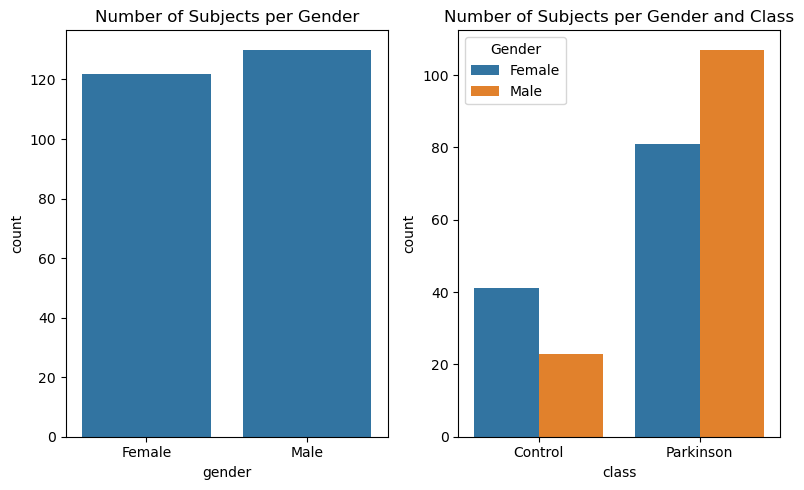

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))  

# Number of subjects per gender
sns.countplot(x=data.drop_duplicates("id")["gender"], ax=ax[0])
ax[0].set_xticks([0, 1], labels=["Female", "Male"])
ax[0].set_title('Number of Subjects per Gender')

# Number of subjects per gender and class
sns.countplot(x=data.drop_duplicates("id")["class"], hue=data["gender"], ax=ax[1])
ax[1].set_xticks([0, 1], labels=["Control", "Parkinson"])
ax[1].legend(title='Gender', labels=['Female', 'Male'])
ax[1].set_title('Number of Subjects per Gender and Class')

plt.tight_layout() 
plt.savefig("Figures/1_Descriptive.png")
plt.show()

In [7]:
# Descriptive statistics of the first 10 columns and the last one
print(data.iloc[:,list(range(10))+[-1]].describe())

               id      gender         PPE         DFA        RPDE   numPulses  \
count  756.000000  756.000000  756.000000  756.000000  756.000000  756.000000   
mean   125.500000    0.515873    0.746284    0.700414    0.489058  323.972222   
std     72.793721    0.500079    0.169294    0.069718    0.137442   99.219059   
min      0.000000    0.000000    0.041551    0.543500    0.154300    2.000000   
25%     62.750000    0.000000    0.762833    0.647053    0.386537  251.000000   
50%    125.500000    1.000000    0.809655    0.700525    0.484355  317.000000   
75%    188.250000    1.000000    0.834315    0.754985    0.586515  384.250000   
max    251.000000    1.000000    0.907660    0.852640    0.871230  907.000000   

       numPeriodsPulses  meanPeriodPulses  stdDevPeriodPulses  locPctJitter  \
count        756.000000        756.000000          756.000000    756.000000   
mean         322.678571          0.006360            0.000383      0.002324   
std           99.402499          

For the first descriptives obtained:

Dataset has 756 rows and 755 columns (749 float numbers, 6 integer)
Fisrt column is patient ID, second column is gender (integer that represents a categorical variable) last column is class (also represented as integer).

For the gender variable there is a balanced data for men (130) and women (122).    
For the class variable there is no balance data: 188 subjects with Parkinson vs. 64 healthy subjects.

There is no null data. 

Data requires normalization: variable PPE min value is arround 0.041 and it's maximum is arround 0.9 with a mean at 0.74. Variable numPulses has a min value of 2 and a max value of 907 with a mean of arround 324. 

## Standarization

For standarization, use MinMaxScaler. 



In [8]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler normalization
scaler = MinMaxScaler(feature_range=(0, 1)) 
data_scaled = scaler.fit_transform(data.iloc[:,1:754])
scaled_df = pd.DataFrame(data_scaled, columns=data.columns[1:754])
scaled_data = pd.concat([data.iloc[:,:1], scaled_df, data.iloc[:,754]], axis=1)

In [9]:
# Create new file with scaled data
scaled_data.to_csv("Data/scaled_data.csv", index=False)

## Statistical analysis 



To perform the statistical analysis, the mean of the three observations for each subject is calculated. All subsequent statistical tests are based on the data obtained from these subject-specific means.

First, each variable is tested for normality using the Shapiro-Wilk test. The data is separated based on the Class variable, and each group is analyzed individually for every variable. If the Shapiro-Wilk test indicates that a variable is normally distributed with 95% confidence, a Levene test is then conducted to assess the equality of variances.

If the variable is normally distributed and exhibits equal variances in both groups, a t-test is performed to compare the means between the two groups (control and Parkinson). If the variable is normally distributed but fails the homoscedasticity assumption, a Welch’s t-test (which assumes unequal variances) is applied. Finally, for variables that are not normally distributed, the non-parametric Mann-Whitney U test is used to assess differences between the two groups.

All statistics and p-values obtainded in the different comparative tests are saved for each variable in a new dataframe. Adjusted p-values are then calculated using the Bonferroni Benjamini-Hochberg (BH) corrections.

In [10]:
# Create a new dataset containing the mean of the three observations for each subject and each variable
grouped_means = scaled_data.groupby("id").mean()

grouped_means.iloc[:,:10].head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter
id,,,,,,,,,,
0,1.0,0.902699,0.494501,0.575998,0.257827,0.258112,0.563004,0.018097,0.063665,0.060390
1,0.0,0.431915,0.810291,0.611152,0.233517,0.232301,0.624066,0.529597,0.202614,0.191355
2,1.0,0.877975,0.247353,0.510877,0.350645,0.351032,0.362259,0.026931,0.072864,0.049613
3,0.0,0.908841,0.267182,0.534060,0.542541,0.543142,0.166314,0.009073,0.019850,0.008916
4,0.0,0.911820,0.763074,0.798428,0.398527,0.398968,0.323664,0.579629,0.122852,0.079285


In [11]:
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests


def compare_groups(data, alpha=0.05):
    '''
    Function to preform comparative statistical tests for each variable between the control and Parkinson groups.
    First, a Shapiro-Wilk normality test is performed, followed by a Levene test for variance equality.
    If normality and equal variances are confirmed, a t-test is used. 
    If normality is found but with unequal variances, Welch's test is applied.
    For non-normally distributed variables, the Mann-Whitney U test is used. 
    Adjusted p-values are calculated using the Bonferroni and BH correction methods.
    A resulting dataframe containing the variable name, compaison test applied, statistics, p-value and corrected 
    p-values is returned.
    '''
    results = []
    for var in data.columns[2:753]:
        gr0 = data[data['class']==0][var]
        gr1 = data[data['class']==1][var]

        # Normality test
        stat0, p0 = shapiro(gr0)
        stat1, p1 = shapiro(gr1)
 
        # Levene test if normality is true
        if p0 > 0.05 and p1 > 0.05:
            stat_var, p_var = levene (gr0, gr1)
            
            # T-test if normality and variance equality
            if p_var > 0.05:
                stat, p_value = ttest_ind(gr0, gr1)
                test_type = "T-Test"
            
            # Welch test if normality but not variance equality
            else :
                stat, p_value = ttest_ind(gr0, gr1, equal_var = False)
                test_type = "Welch"
                
        # Mann-Whitney U test if not normality
        else:
                stat, p_value = mannwhitneyu(gr0, gr1)
                test_type = "Mann-Whitney U"
                
                
        results.append({
            "Variable":var,
            "Test": test_type,
            "Statistic": stat,
            "P-value": p_value
        })
                
    results_df = pd.DataFrame(results)
    
    
    # Extract p-values for correction
    p_values = results_df["P-value"].values
    
    # Bonferroni correction
    bonferroni_results = multipletests(p_values, alpha=alpha, method='bonferroni')
    results_df["Adjusted p-value (Bonferroni)"] = bonferroni_results[1]
    
    # BH correction
    bh_results = multipletests(p_values, alpha=alpha, method='fdr_bh')
    results_df["Adjusted p-value (BH)"] = bh_results[1]
        
    results_df = results_df.round(4)
    
    return results_df           

In [12]:
# Comparison study
stats_compare_df= compare_groups(grouped_means)
stats_compare_df.head().to_csv('Tables/2_stats_compare_df.csv', index=False)
stats_compare_df.head()

,Variable,Test,Statistic,P-value,Adjusted p-value (Bonferroni),Adjusted p-value (BH)
0,DFA,T-Test,-5.3843,0.0,0.0001,0.0000
1,RPDE,T-Test,-4.3936,0.0,0.0124,0.0001
2,numPulses,Mann-Whitney U,8231.0000,0.0,0.0082,0.0001
3,numPeriodsPulses,Mann-Whitney U,8240.0000,0.0,0.0076,0.0001
4,meanPeriodPulses,Mann-Whitney U,3908.0000,0.0,0.0215,0.0001


In [13]:
# Get the variables with Bonferroni adjusted p-values < 0.05
var_Bf = stats_compare_df[stats_compare_df["Adjusted p-value (Bonferroni)"] < 0.05]['Variable'].tolist()
stats_compare_df[stats_compare_df["Adjusted p-value (Bonferroni)"] < 0.05]

,Variable,Test,Statistic,P-value,Adjusted p-value (Bonferroni),Adjusted p-value (BH)
0,DFA,T-Test,-5.3843,0.0,0.0001,0.0000
1,RPDE,T-Test,-4.3936,0.0,0.0124,0.0001
2,numPulses,Mann-Whitney U,8231.0000,0.0,0.0082,0.0001
3,numPeriodsPulses,Mann-Whitney U,8240.0000,0.0,0.0076,0.0001
4,meanPeriodPulses,Mann-Whitney U,3908.0000,0.0,0.0215,0.0001
...,...,...,...,...,...,...
741,tqwt_kurtosisValue_dec_27,Mann-Whitney U,8378.5000,0.0,0.0021,0.0000
742,tqwt_kurtosisValue_dec_28,Mann-Whitney U,8244.0000,0.0,0.0073,0.0001
748,tqwt_kurtosisValue_dec_34,Mann-Whitney U,3646.0000,0.0,0.0019,0.0000
749,tqwt_kurtosisValue_dec_35,Mann-Whitney U,3469.0000,0.0,0.0003,0.0000


In [14]:
# Get the variables with BH adjusted p-values < 0.05
var_BH = stats_compare_df[stats_compare_df["Adjusted p-value (BH)"] < 0.05]['Variable'].tolist()
stats_compare_df[stats_compare_df["Adjusted p-value (BH)"] < 0.05]

,Variable,Test,Statistic,P-value,Adjusted p-value (Bonferroni),Adjusted p-value (BH)
0,DFA,T-Test,-5.3843,0.0000,0.0001,0.0000
1,RPDE,T-Test,-4.3936,0.0000,0.0124,0.0001
2,numPulses,Mann-Whitney U,8231.0000,0.0000,0.0082,0.0001
3,numPeriodsPulses,Mann-Whitney U,8240.0000,0.0000,0.0076,0.0001
4,meanPeriodPulses,Mann-Whitney U,3908.0000,0.0000,0.0215,0.0001
...,...,...,...,...,...,...
743,tqwt_kurtosisValue_dec_29,Mann-Whitney U,7181.0000,0.0208,1.0000,0.0378
747,tqwt_kurtosisValue_dec_33,Mann-Whitney U,4473.0000,0.0022,1.0000,0.0052
748,tqwt_kurtosisValue_dec_34,Mann-Whitney U,3646.0000,0.0000,0.0019,0.0000
749,tqwt_kurtosisValue_dec_35,Mann-Whitney U,3469.0000,0.0000,0.0003,0.0000


In [15]:
diff_var = [var for var in var_Bf if var in var_BH]
len(diff_var)

223

Bonferroni-adjusted p-values show 223 variables to be statistically significant different between the two experimental groups, while BH-adjusted p-values identify 424 variables as statistically different between groups with 95% confidence. In fact, all statistically significant variables determined by Bonferroni-adjusted p-values are also included in the list of variables identified as statistically significant by BH-adjusted p-values.

A list of variables determined to be statistically significant with both adjusted p-values (95% confidence) is generated. 
The first 4 variables are ploted according to Class group.

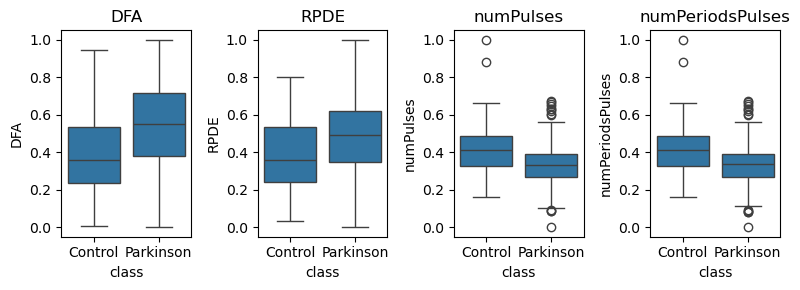

In [17]:
# Plot first 4 significantly different variables between group
fig, axes = plt.subplots(1, 4, figsize=(8, 3))  

for i, col in enumerate(diff_var[:4]):  
    sns.boxplot(x=scaled_data["class"], y=scaled_data[col], ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["Control", "Parkinson"]) 

plt.tight_layout() 
plt.savefig("Figures/2_Stat_var_per_class.png")
plt.show()

Few randomly selected features from the statistically significant variables found to be different between groups are ploted against each other using pairplot.

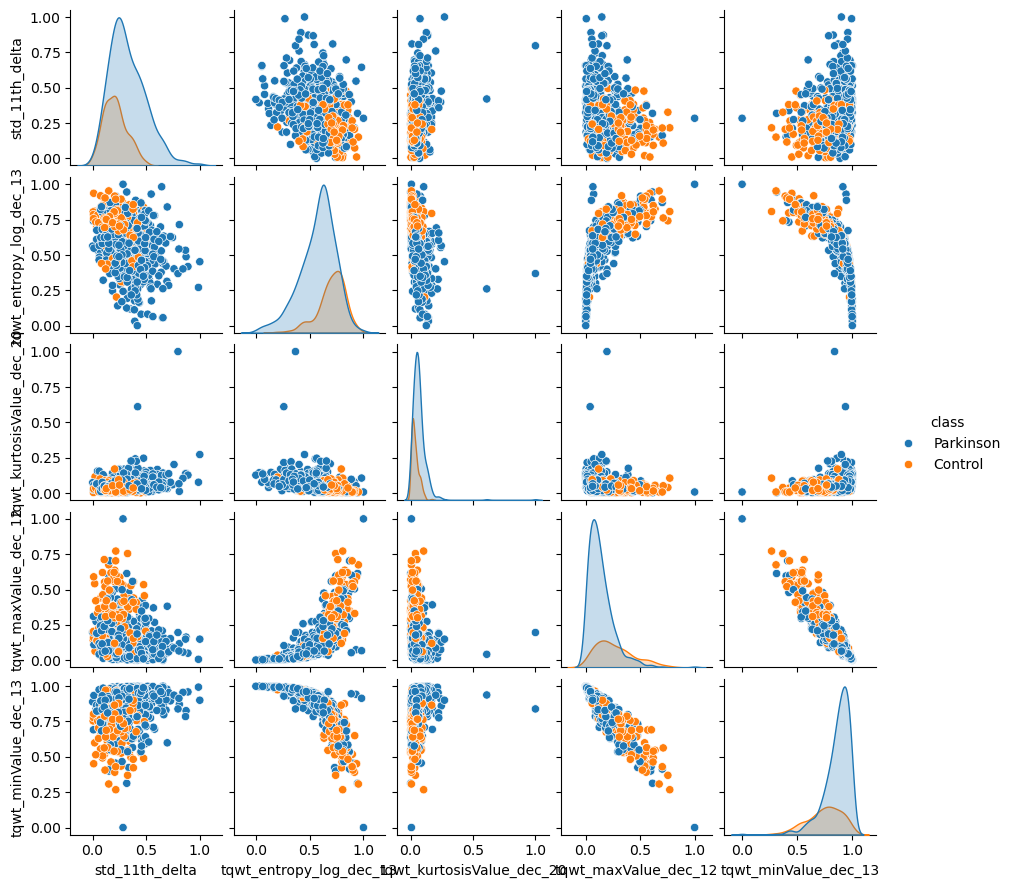

In [18]:
import random

# Plot 5 statistically significant different variables with pariplot
random.seed(1)
rdm_var = random.sample(diff_var,5)
subset = scaled_data[rdm_var].copy()

subset['class'] = scaled_data['class']
subset['class'] = subset['class'].replace({0: 'Control', 1: 'Parkinson'})

sns.pairplot(subset, hue='class', height=1.8) # Color by class
plt.savefig("Figures/3_Pairplot.png")
plt.show()

Some of the randomly selected variables are related to each other. Additionally, while the blue and orange dots are interspersed across all graphs, in certain plots, they appear to cluster. 